In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, datetime, DataFrame, concat
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from numpy import asarray
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller


/var/folders/pt/xwz928fd2l973b6cv37cynzc0000gn/T/ipykernel_32965/1974265111.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import read_csv, datetime, DataFrame, concat


In [3]:
df_cases = pd.read_csv("Cases.csv", encoding= 'unicode_escape')

In [4]:
# clean cases data and convert them to numeric
df_cases = df_cases.applymap(lambda x: x.strip())
df_cases = df_cases.applymap(lambda x: x.replace(",", ""))
df_cases = df_cases.applymap(lambda x: x.replace("..", ""))

counties = df_cases.columns[1:]
for county in counties:
    df_cases[county] = pd.to_numeric(df_cases[county],errors='coerce')

df_cases = df_cases.fillna(0)

In [5]:
# display df test for all counties to detect if there are trends
def county_plots(counties, file_name=None):
    figure = plt.gcf()
    figure.set_size_inches(20, 20)
    figure.suptitle('County Trends (Dickey Fuller Test)', fontsize=18)
    plt.rcParams['figure.constrained_layout.use'] = False

    for idx, county in enumerate(counties):
        result = adfuller(df_cases[county].dropna())
        ax = figure.add_subplot(8, 4, idx+1)
        plt.title("County " + county + (' (p-value: %.3f)' % result[1]), fontsize=13)
        plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
        ax.set_xlabel('Week'); ax.set_ylabel('cases')
        df_cases[county].plot(ax=ax)
    
    if file_name:
        plt.savefig(file_name, dpi=300, bbox_inches="tight")
    plt.show()

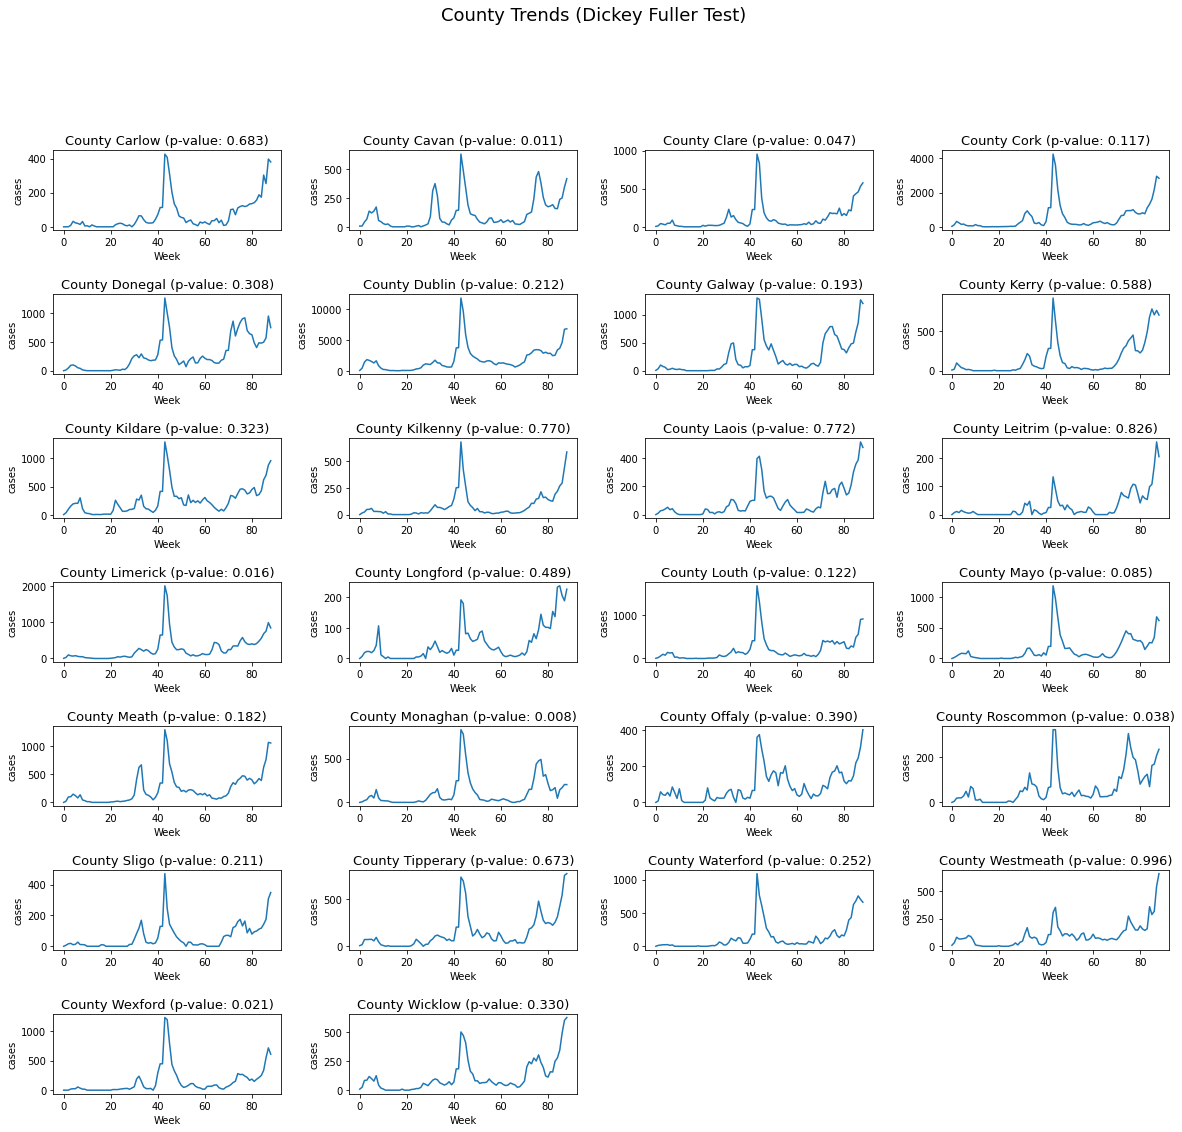

In [6]:
county_plots(counties, file_name='all_counties_without_diff')

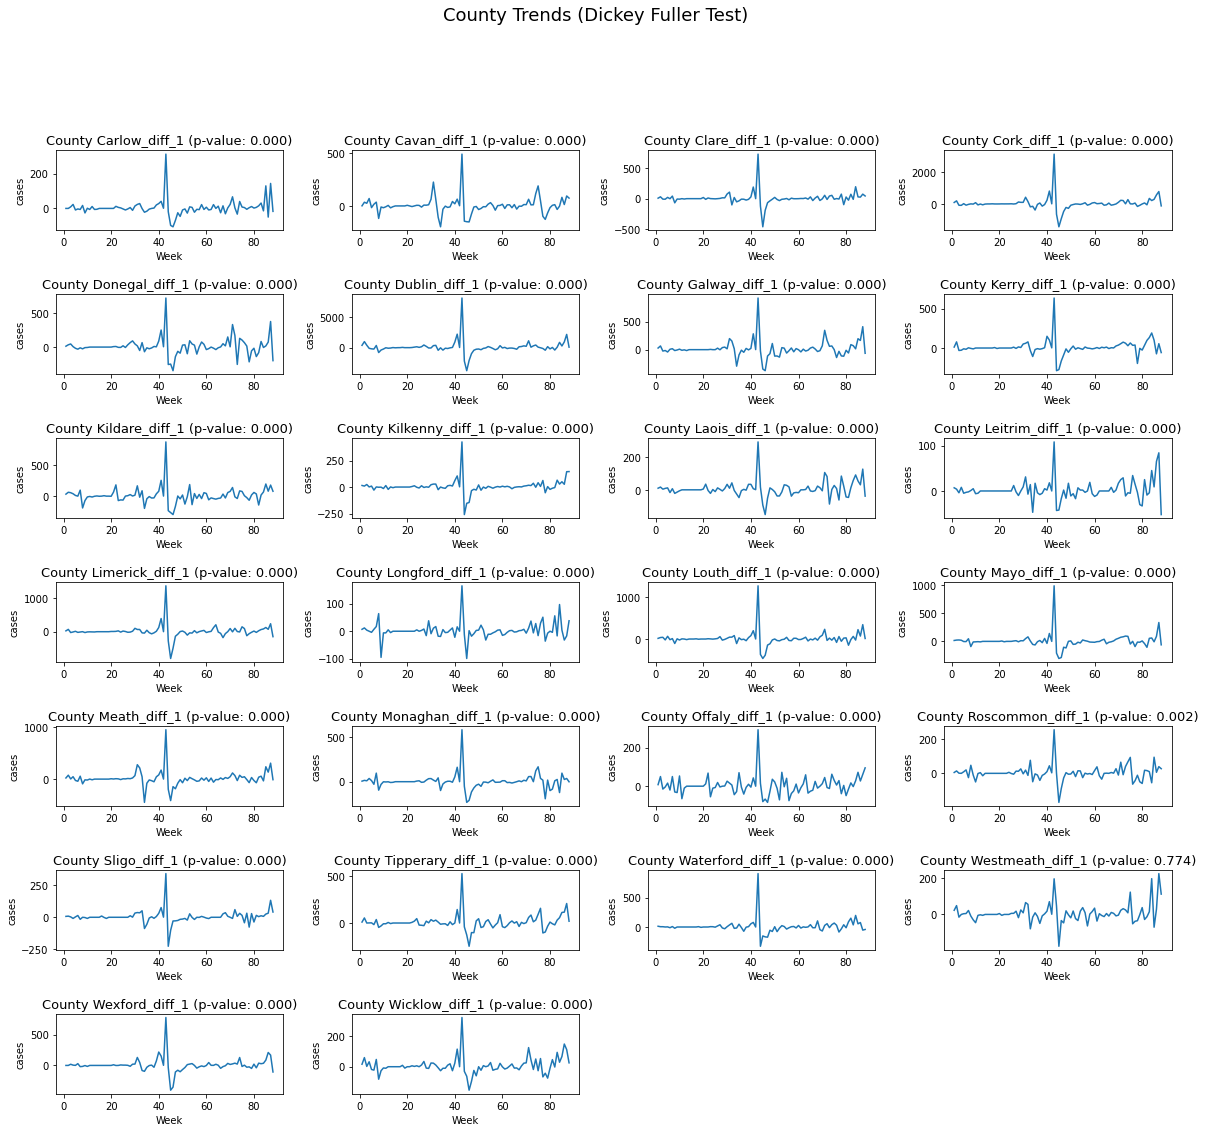

In [7]:
# remove trends by differencing
new_cols = []
for county in counties:
    new_cols.append(county + "_diff_1")
    df_cases[county + "_diff_1"] = df_cases[county].diff(periods=1)

county_plots(new_cols, 'counties_after_diff_1')

# 1st differenced ordered counties
counties_order_1 = [county for county in new_cols if county != 'Westmeath_diff_1']

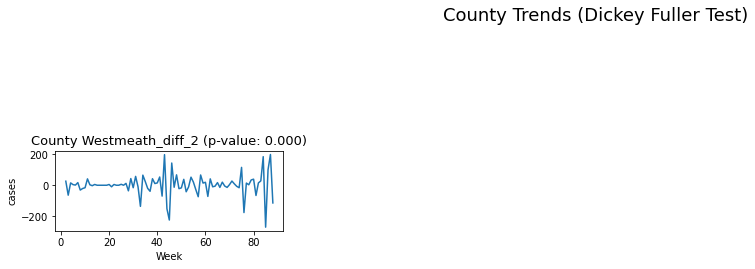

In [8]:

# since westmeath was not stationary after 1st differencing, we have introduced 2nd order difference
df_cases["Westmeath_diff_2"] = df_cases["Westmeath_diff_1"].diff(periods=1)
county_plots(["Westmeath_diff_2"], 'Westmeath_diff_2')

counties_order_2 = ['Westmeath_diff_2']

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX, n_estimators=1000):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=n_estimators)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, n_est):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX, n_est)
        
        # store forecast in list of predictions
        predictions.append(yhat)
        
        # add actual observation to history for the next loop
        history.append(test[i])

    
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    rmse = mean_squared_error(test[:, -1], predictions,squared=False)
    return error,rmse, test[:, -1], predictions

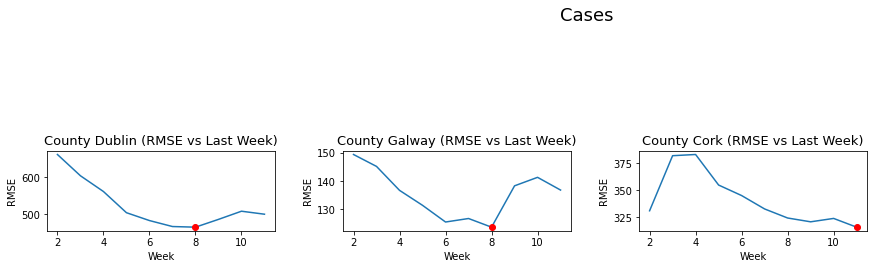

In [10]:
# hyperparameter selection for number of last weeks input
last_week_range = [* range(2, 12)]
weeks_test = 12

figure = plt.gcf()
figure.set_size_inches(20, 20)
figure.suptitle('Cases', fontsize=18)
plt.rcParams['figure.constrained_layout.use'] = False

counties = ['Dublin_diff_1', 'Galway_diff_1', 'Cork_diff_1']

for idx, county in enumerate(counties):
    rmse_list = []
    for last_week in last_week_range:
        data = series_to_supervised(df_cases[[county]].values, n_in=last_week)
        mae,rmse, y, yhat = walk_forward_validation(data, weeks_test, n_est=2000)
        rmse_list.append(rmse)

    min_rmse = min(rmse_list)
    min_week = last_week_range[rmse_list.index(min_rmse)]

    ax = figure.add_subplot(8, 4, idx+1)
    plt.title("County %s (RMSE vs Last Week)" % (county.split('_')[0]), fontsize=13)
    plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
    ax.plot(last_week_range, rmse_list)
    ax.plot(min_week,min_rmse,'ro')
    ax.set_xlabel('Week'); ax.set_ylabel('RMSE')


plt.savefig('order_1_counties_rmse', dpi=300, bbox_inches="tight")

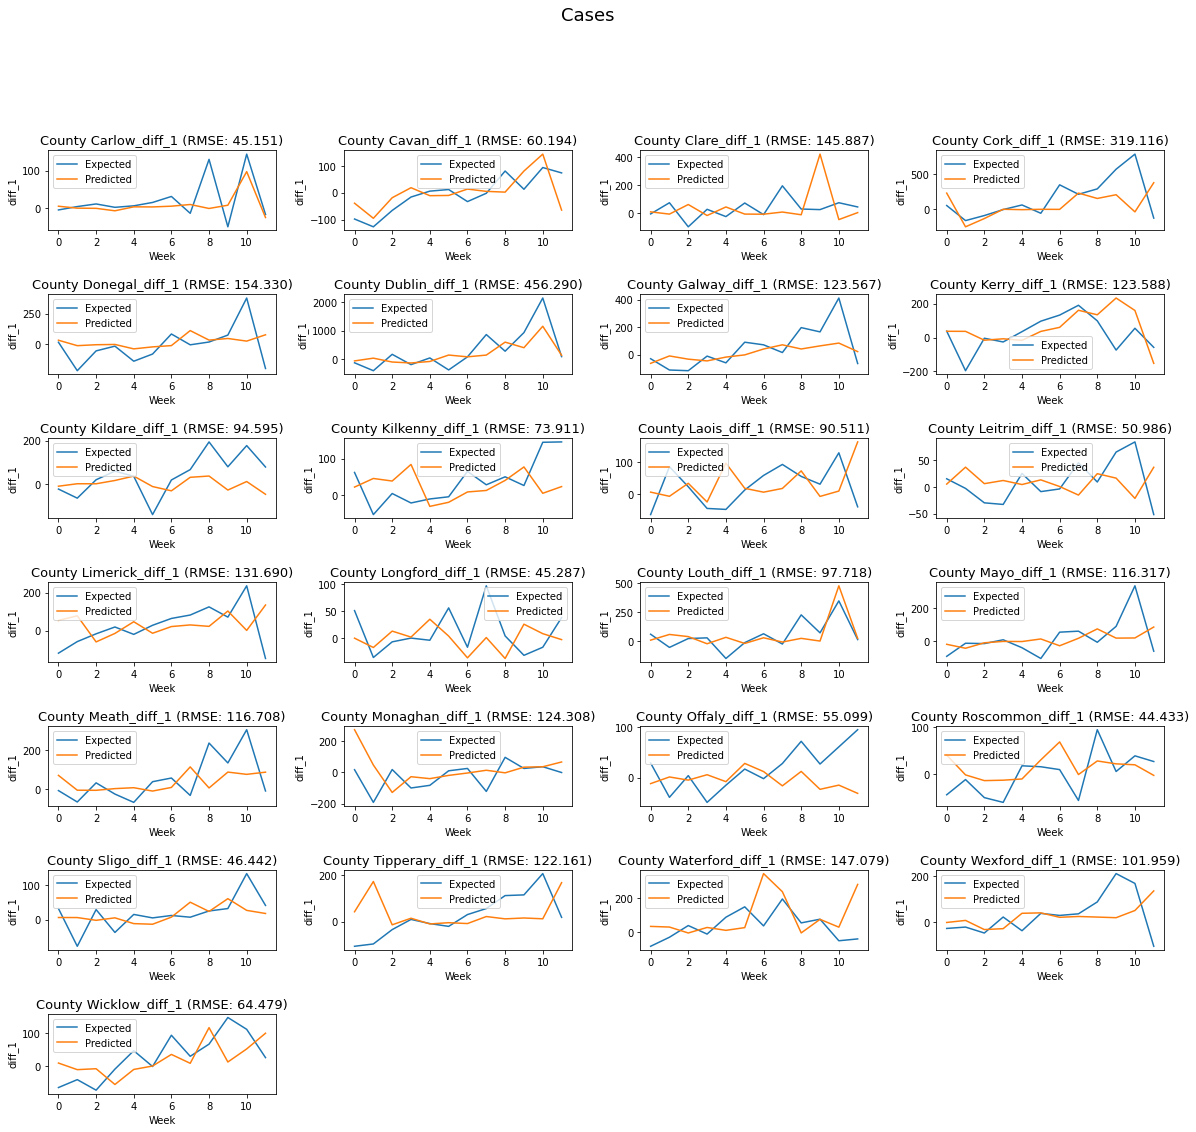

In [197]:
# all counties 1st order .. the code takes a lot of time to run.
weeks_test = 12
last_weeks_input = 8

figure = plt.gcf()
figure.set_size_inches(20, 20)
figure.suptitle('Cases', fontsize=18)
plt.rcParams['figure.constrained_layout.use'] = False

for idx, county in enumerate(counties_order_1):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)

    # evaluate
    mae,rmse, y, yhat = walk_forward_validation(data, weeks_test, n_est=2000)
    
    ax = figure.add_subplot(8, 4, idx+1)
    plt.title("County " + county + (' (RMSE: %.3f)' % rmse), fontsize=13)
    plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
    ax.plot(y, label='Expected')
    ax.plot(yhat, label='Predicted')
    ax.legend()
    ax.set_xlabel('Week'); ax.set_ylabel('diff_1')

plt.savefig('order_1_counties_eval', dpi=300, bbox_inches="tight")
pyplot.show()

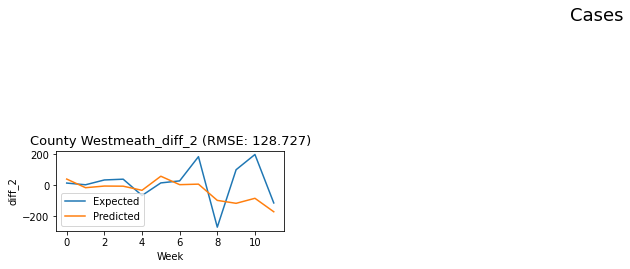

In [198]:
# all counties 2nd order
weeks_test = 12
last_weeks_input = 8

figure = plt.gcf()
figure.set_size_inches(20, 20)
figure.suptitle('Cases', fontsize=18)
plt.rcParams['figure.constrained_layout.use'] = False

for idx, county in enumerate(counties_order_2):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)

    # evaluate
    mae,rmse, y, yhat = walk_forward_validation(data, weeks_test, n_est=2000)
    
    ax = figure.add_subplot(8, 4, idx+1)
    plt.title("County " + county + (' (RMSE: %.3f)' % rmse), fontsize=13)
    plt.subplots_adjust(wspace = 0.3, hspace= 0.8)
    ax.plot(y, label='Expected')
    ax.plot(yhat, label='Predicted')
    ax.legend()
    ax.set_xlabel('Week'); ax.set_ylabel('diff_2')

plt.savefig('order_2_county_eval', dpi=300, bbox_inches="tight")
pyplot.show()

In [214]:
# counties 1st order predictions
def future_predictions(county, weeks_ahead = 4):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)
    # split into input and output columns

    trainX, trainy = data[:, :-1], data[:, -1]

    # fit model
    model = RandomForestRegressor(n_estimators=2000)
    model.fit(trainX, trainy)


    # construct an input for a new prediction
    row = df_cases[[county]].values[-last_weeks_input:].flatten()
    last_cases = df_cases[county.split('_')[0]].values[-1:][0]

    prediction = []
    
    for i in range(weeks_ahead):
        yhat = model.predict(asarray([row]))

        
        # print('Input: %s, Predicted: %.3f' % (row, yhat[0] + last_cases))
        # invert
        
        prediction.append(yhat[0] + last_cases)
        
        row = np.append(row, round(yhat[0]))
        row = np.delete(row, 0)
        last_cases = yhat[0] + last_cases
    return prediction

In [215]:
# meath 2nd order predictions
def future_predictions_order_2(county, weeks_ahead = 4):
    data = series_to_supervised(df_cases[[county]].values, n_in=last_weeks_input)
    
    # split into input and output columns
    trainX, trainy = data[:, :-1], data[:, -1]

    # fit model
    model = RandomForestRegressor(n_estimators=2000)
    model.fit(trainX, trainy)


    # construct an input for a new prediction
    row = df_cases[[county + '_diff_2']].values[-last_weeks_input:].flatten()
    last_cases = df_cases[county.split('_')[0]].values[-1:][0] + df_cases[county.split('_')[0] + '_diff_1'].values[-1:][0]

    prediction = []

    for i in range(weeks_ahead):
        yhat = model.predict(asarray([row]))

        prediction.append(yhat[0] + last_cases)

        row = np.append(row, round(yhat[0]))
        row = np.delete(row, 0)
        last_cases = yhat[0] + last_cases
    return prediction

In [220]:
county_pred = []

for county in counties_order_1:
    preds = future_predictions(county, 4)
    print('%s county : %s' % (county.split('_')[0], preds))
    county_pred.append((county, preds))
    
# handling 2nd order diff separately
county_pred.append(('Westmeath_diff', future_predictions_order_2("Westmeath")))

Carlow county : [429.8295, 415.457, 463.504, 453.9945]
Cavan county : [573.2595, 581.6315, 702.944, 694.6324999999999]
Clare county : [613.0315, 648.0665, 673.8655, 684.268]
Cork county : [4224.2919999999995, 4066.8669999999993, 5248.845499999999, 5147.7045]
Donegal county : [897.795, 925.7960999999999, 1002.6670999999999, 1024.3855999999998]
Dublin county : [11200.4475, 10955.607, 13268.603500000001, 13290.248500000002]
Galway county : [1387.091, 1371.5379999999998, 1403.1324999999997, 1348.7304999999997]
Kerry county : [612.27, 549.5314999999999, 506.00149999999996, 510.50199999999995]
Kildare county : [1028.5985, 1008.6535, 987.5575, 968.5575]
Kilkenny county : [799.1345, 919.778, 1023.702, 1117.677]
Laois county : [547.7155, 597.724, 604.5708333333333, 608.1958333333333]
Leitrim county : [209.576, 209.0575, 223.419, 248.85750000000002]
Limerick county : [809.0315, 698.5195000000001, 654.8015000000001, 632.1760000000002]
Longford county : [243.7025, 253.712, 252.97899999999998, 267.

In [221]:
sorted_counties = sorted(county_pred, key=lambda x: x[1][1],reverse=True)

In [222]:
# 3 counties with largest cases for 4 weeks
for county in sorted_counties[:3]:
    print('%s county : %s' % (county[0].split('_')[0], county[1]))

Dublin county : [11200.4475, 10955.607, 13268.603500000001, 13290.248500000002]
Cork county : [4224.2919999999995, 4066.8669999999993, 5248.845499999999, 5147.7045]
Galway county : [1387.091, 1371.5379999999998, 1403.1324999999997, 1348.7304999999997]
